# NNTI Assignment 8 (Q8.4)

Name 1: Tarun Hariharan <br>
Student id 1: 7062505 <br>
Email 1: taha00002@stud.uni-saarland.de <br>

Name 2: Prakhar Narain Srivastava <br>
Student id 2: 7062507 <br>
Email 2: prsr00001@stud.uni-saarland.de <br>

Name 3: Bilal Amin <br>
Student id 3: 7061951 <br>
Email 3: biam00002@stud.uni-saarland.de <br>

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the respective  files for any additional exercises necessary. There is no need to resubmit the data files should they be provided separately. <br>


Upload the zipped folder on CMS. Please follow the naming convention of **Name1_id1_Name2_id2_Name3_id3.zip **. Only one member of the group should make the submisssion.


In this exercise you will build your own neural networks, but this time you need to add regularization in the form of dropout, weight-decay and early-stopping.

Each layer should have the option of using dropout. Your code needs to allow for this flexibility.

Additionally, adding weight-decay and early-stopping should also be optional upon creation.

**NOTE**:
1. You are allowed to use built-in functions from pytorch to incorporate this functionality.

2. We recommend the use of GPUs or Google collab for this exercise.

3. During training and validation, remember when to use `model.train()` and `model.eval()`

Use the below imports, as usual you are allowed to import additional packages, but mention the reason you're using them

In [18]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm  
import numpy as np
import torch.nn.functional as F




## a. Implement a regularized model [0.5 points]

In this task, you will implement a custom neural network model using PyTorch. The model should incorporate key features such as **dropout** to improve generalization and prevent overfitting.

**Tasks to implement**:

1. Define the Model Architecture:
  - The model consists of a series of fully connected (FC) layers with ReLU activations in between.
  - Dropout layers are added after each hidden layer, with the probability of dropout specified by the `dropout_p` parameter.
  - The final output layer produces a result that is passed through a Softmax activation for multi-class classification tasks.

**Hint**:
Since you're not implementing a CNN, but rather a simple ANN network, it is recommended to flatten your input images when pushing into the network.

In [19]:
class MyModel(nn.Module):
    """
    A neural network model with flexible architecture incorporating dropout.

    Args:
        input_dim (int): Dimensionality of the input features.
        hidden_dims (list): List of units in each hidden layer.
        output_dim (int): Number of output units (number of classes).
        dropout_probs (list): List of dropout probabilities for each layer.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_probs):
        super(MyModel, self).__init__()
        self.layers = nn.ModuleList()
        
        # Define input layer
        prev_dim = input_dim
        for hidden_dim, dropout_prob in zip(hidden_dims, dropout_probs):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            if dropout_prob > 0:
                self.layers.append(nn.Dropout(p=dropout_prob))
            prev_dim = hidden_dim
        
        # Output layer
        self.layers.append(nn.Linear(prev_dim, output_dim))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        for layer in self.layers[:-1]:  # Apply all layers except the output
            x = layer(x)
        x = self.layers[-1](x)  # Output layer
        x = F.softmax(x, dim=1)  # Apply softmax for classification
        return x

### b. Data and code setup [1 + 0.25 + 0.25 = 1.5 points]

You will use the MNIST dataset for these experiments. The data setup has been provided for you.<br> **DO NOT CHANGE THE CODE HERE.**

In [20]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_train))  # 80% for training
val_size = len(mnist_train) - train_size  # 20% for validation

# Split the dataset into training and validation
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

#### Training code
The `trainer()` function trains a model using the provided data loaders, criterion (loss function), optimizer, and various options for regularization and early stopping. You will implement this function for training models for the experiments.

Few things to keep in mind:
- The function should accept model, data loaders, loss function, optimizer, and training configurations (epochs, early stopping).
- The training loop should include forward pass, loss computation, backward pass, and weight update.
- Track and return average training and validation losses for each epoch.
- Use tqdm for progress bars during training and validation. (**optional**, but recommended)
- Implement **early stopping** to halt training if validation loss doesn't improve for a set number of epochs. Provide a `patience` parameter as the number of epochs to wait until validation loss improves.
  - Make it optional by passing a boolean param `early_stopping`.

In [21]:


def trainer(model, train_loader, val_loader, criterion, optimizer, epochs=50, early_stopping=False, patience=10):
    """
    Train the model with optional early stopping.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        criterion (loss function): The loss function.
        optimizer (Optimizer): The optimizer to use.
        epochs (int, optional): The number of epochs to train. Default is 50.
        early_stopping (bool, optional): Whether to apply early stopping. Default is False.
        patience (int, optional): The patience for early stopping. Default is 10.

    Returns:
        model (torch.nn.Module): The trained model.
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model, train_losses, val_losses


#### Evaluation code

Complete the `plot_losses()` function and `evaluate_model()` to visualize the training and validation losses and to evaluate the model over the test set.

**NOTE**:
1. Add a legend, title, and grid to improve plot readability for `plot_losses()`
2. Report the average test loss, accuracy, and F1 score metrics using `evaluate_model()`.


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses.

    Args:
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.title("Training and Validation Losses", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

def evaluate_model(model, test_loader, criterion):
    """
    Evaluate the model on the test set and report accuracy and F1 score.

    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        test_loader (DataLoader): The test data loader.
        criterion (loss function): The loss function to use for evaluation.

    Returns:
        float: The average test loss.
        float: The accuracy of the model on the test set.
        float: The F1 score of the model on the test set.
    """
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average="weighted")

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    return test_loss, accuracy, f1


## c. Experiments: [0.25+0.25+0.25+0.25 = 1 point]
Build a deep network using 3 hidden layers, so in total including input and output layers, it shoudl be a 5-layer network. You will run the following 4 experiments on this network with the given configurations:

1. Deep network (at least 3 hidden layers)
2. Deep regularized network (with weight-decay enabled)
3. Deep regularized network (with weight-decay and dropout)
4. Deep regularized network (with weight-decay and early-stopping)

Report Accuracy and $F_1$ metrics on the `test set` for your experiments and discuss your results. What did you expect to see and what did you end up seeing.

**NOTE**:
- You can choose how you use regularization. Ideally you would experiment with various parameters for this regularization, the 4 listed variants are merely what you must cover as a minimum. You are free to run more experiments if you want to.
- In the end, report results for all your experiments on the test set concisely  in a table at the end.
- Use the Adam optimizer for all of your experiments.

### Experiment 1: Deep network (at least 3 hidden layers) (No Regularization)

Use the given model configs and hyperparams to run the experiments.

In [23]:
import torch.optim as optim

# Deep network (3 hidden layers) with no dropout and no weight-decay
model_1_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}


learning_rate = 5e-5
weight_decay = 0  # Use this only if weight-decay is needed

Validation Epoch 1/50: 100%|██████████| 188/188 [00:00<00:00, 376.38it/s]


Epoch 1/50, Train Loss: 1.8170, Val Loss: 1.6600


Validation Epoch 2/50: 100%|██████████| 188/188 [00:00<00:00, 379.53it/s]


Epoch 2/50, Train Loss: 1.6038, Val Loss: 1.5831


Validation Epoch 3/50: 100%|██████████| 188/188 [00:00<00:00, 367.08it/s]


Epoch 3/50, Train Loss: 1.5663, Val Loss: 1.5641


Validation Epoch 4/50: 100%|██████████| 188/188 [00:00<00:00, 376.77it/s]


Epoch 4/50, Train Loss: 1.5544, Val Loss: 1.5553


Validation Epoch 5/50: 100%|██████████| 188/188 [00:00<00:00, 383.87it/s]


Epoch 5/50, Train Loss: 1.5456, Val Loss: 1.5491


Validation Epoch 6/50: 100%|██████████| 188/188 [00:00<00:00, 336.41it/s]


Epoch 6/50, Train Loss: 1.5395, Val Loss: 1.5458


Validation Epoch 7/50: 100%|██████████| 188/188 [00:00<00:00, 381.75it/s]


Epoch 7/50, Train Loss: 1.5339, Val Loss: 1.5404


Validation Epoch 8/50: 100%|██████████| 188/188 [00:00<00:00, 383.50it/s]


Epoch 8/50, Train Loss: 1.5287, Val Loss: 1.5337


Validation Epoch 9/50: 100%|██████████| 188/188 [00:00<00:00, 385.82it/s]


Epoch 9/50, Train Loss: 1.5244, Val Loss: 1.5304


Validation Epoch 10/50: 100%|██████████| 188/188 [00:00<00:00, 382.52it/s]


Epoch 10/50, Train Loss: 1.5199, Val Loss: 1.5288


Validation Epoch 11/50: 100%|██████████| 188/188 [00:00<00:00, 382.97it/s]


Epoch 11/50, Train Loss: 1.5169, Val Loss: 1.5244


Validation Epoch 12/50: 100%|██████████| 188/188 [00:00<00:00, 378.79it/s]


Epoch 12/50, Train Loss: 1.5137, Val Loss: 1.5213


Validation Epoch 13/50: 100%|██████████| 188/188 [00:00<00:00, 378.66it/s]


Epoch 13/50, Train Loss: 1.5110, Val Loss: 1.5194


Validation Epoch 14/50: 100%|██████████| 188/188 [00:00<00:00, 380.37it/s]


Epoch 14/50, Train Loss: 1.5081, Val Loss: 1.5161


Validation Epoch 15/50: 100%|██████████| 188/188 [00:00<00:00, 379.15it/s]


Epoch 15/50, Train Loss: 1.5064, Val Loss: 1.5137


Validation Epoch 16/50: 100%|██████████| 188/188 [00:00<00:00, 360.45it/s]


Epoch 16/50, Train Loss: 1.5035, Val Loss: 1.5136


Validation Epoch 17/50: 100%|██████████| 188/188 [00:00<00:00, 380.97it/s]


Epoch 17/50, Train Loss: 1.5018, Val Loss: 1.5126


Validation Epoch 18/50: 100%|██████████| 188/188 [00:00<00:00, 328.48it/s]


Epoch 18/50, Train Loss: 1.4999, Val Loss: 1.5100


Validation Epoch 19/50: 100%|██████████| 188/188 [00:00<00:00, 370.50it/s]


Epoch 19/50, Train Loss: 1.4981, Val Loss: 1.5090


Validation Epoch 20/50: 100%|██████████| 188/188 [00:00<00:00, 372.73it/s]


Epoch 20/50, Train Loss: 1.4963, Val Loss: 1.5075


Validation Epoch 21/50: 100%|██████████| 188/188 [00:00<00:00, 369.90it/s]


Epoch 21/50, Train Loss: 1.4948, Val Loss: 1.5041


Validation Epoch 22/50: 100%|██████████| 188/188 [00:00<00:00, 375.01it/s]


Epoch 22/50, Train Loss: 1.4931, Val Loss: 1.5040


Validation Epoch 23/50: 100%|██████████| 188/188 [00:00<00:00, 370.78it/s]


Epoch 23/50, Train Loss: 1.4917, Val Loss: 1.5025


Validation Epoch 24/50: 100%|██████████| 188/188 [00:00<00:00, 369.66it/s]


Epoch 24/50, Train Loss: 1.4907, Val Loss: 1.5012


Validation Epoch 25/50: 100%|██████████| 188/188 [00:00<00:00, 334.54it/s]


Epoch 25/50, Train Loss: 1.4890, Val Loss: 1.5004


Validation Epoch 26/50: 100%|██████████| 188/188 [00:00<00:00, 375.16it/s]


Epoch 26/50, Train Loss: 1.4880, Val Loss: 1.4984


Validation Epoch 27/50: 100%|██████████| 188/188 [00:00<00:00, 369.94it/s]


Epoch 27/50, Train Loss: 1.4872, Val Loss: 1.5005


Validation Epoch 28/50: 100%|██████████| 188/188 [00:00<00:00, 356.05it/s]


Epoch 28/50, Train Loss: 1.4860, Val Loss: 1.4998


Validation Epoch 29/50: 100%|██████████| 188/188 [00:00<00:00, 373.07it/s]


Epoch 29/50, Train Loss: 1.4849, Val Loss: 1.4992


Validation Epoch 30/50: 100%|██████████| 188/188 [00:00<00:00, 366.27it/s]


Epoch 30/50, Train Loss: 1.4839, Val Loss: 1.5019


Validation Epoch 31/50: 100%|██████████| 188/188 [00:00<00:00, 371.68it/s]


Epoch 31/50, Train Loss: 1.4831, Val Loss: 1.4964


Validation Epoch 32/50: 100%|██████████| 188/188 [00:00<00:00, 372.64it/s]


Epoch 32/50, Train Loss: 1.4825, Val Loss: 1.4968


Validation Epoch 33/50: 100%|██████████| 188/188 [00:00<00:00, 366.41it/s]


Epoch 33/50, Train Loss: 1.4818, Val Loss: 1.4958


Validation Epoch 34/50: 100%|██████████| 188/188 [00:00<00:00, 369.15it/s]


Epoch 34/50, Train Loss: 1.4812, Val Loss: 1.4948


Validation Epoch 35/50: 100%|██████████| 188/188 [00:00<00:00, 372.50it/s]


Epoch 35/50, Train Loss: 1.4806, Val Loss: 1.4950


Validation Epoch 36/50: 100%|██████████| 188/188 [00:00<00:00, 354.46it/s]


Epoch 36/50, Train Loss: 1.4794, Val Loss: 1.4953


Validation Epoch 37/50: 100%|██████████| 188/188 [00:00<00:00, 332.73it/s]


Epoch 37/50, Train Loss: 1.4790, Val Loss: 1.4940


Validation Epoch 38/50: 100%|██████████| 188/188 [00:00<00:00, 370.05it/s]


Epoch 38/50, Train Loss: 1.4785, Val Loss: 1.4930


Validation Epoch 39/50: 100%|██████████| 188/188 [00:00<00:00, 369.04it/s]


Epoch 39/50, Train Loss: 1.4782, Val Loss: 1.4955


Validation Epoch 40/50: 100%|██████████| 188/188 [00:00<00:00, 367.66it/s]


Epoch 40/50, Train Loss: 1.4777, Val Loss: 1.4916


Validation Epoch 41/50: 100%|██████████| 188/188 [00:00<00:00, 371.11it/s]


Epoch 41/50, Train Loss: 1.4774, Val Loss: 1.4927


Validation Epoch 42/50: 100%|██████████| 188/188 [00:00<00:00, 366.85it/s]


Epoch 42/50, Train Loss: 1.4767, Val Loss: 1.4913


Validation Epoch 43/50: 100%|██████████| 188/188 [00:00<00:00, 362.58it/s]


Epoch 43/50, Train Loss: 1.4763, Val Loss: 1.4936


Validation Epoch 44/50: 100%|██████████| 188/188 [00:00<00:00, 350.96it/s]


Epoch 44/50, Train Loss: 1.4758, Val Loss: 1.4922


Validation Epoch 45/50: 100%|██████████| 188/188 [00:00<00:00, 356.25it/s]


Epoch 45/50, Train Loss: 1.4759, Val Loss: 1.4913


Validation Epoch 46/50: 100%|██████████| 188/188 [00:00<00:00, 360.25it/s]


Epoch 46/50, Train Loss: 1.4753, Val Loss: 1.4916


Validation Epoch 47/50: 100%|██████████| 188/188 [00:00<00:00, 342.94it/s]


Epoch 47/50, Train Loss: 1.4750, Val Loss: 1.4918


Validation Epoch 48/50: 100%|██████████| 188/188 [00:00<00:00, 352.37it/s]


Epoch 48/50, Train Loss: 1.4741, Val Loss: 1.4919


Validation Epoch 49/50: 100%|██████████| 188/188 [00:00<00:00, 314.74it/s]


Epoch 49/50, Train Loss: 1.4745, Val Loss: 1.4935


Validation Epoch 50/50: 100%|██████████| 188/188 [00:00<00:00, 350.05it/s]


Epoch 50/50, Train Loss: 1.4739, Val Loss: 1.4918


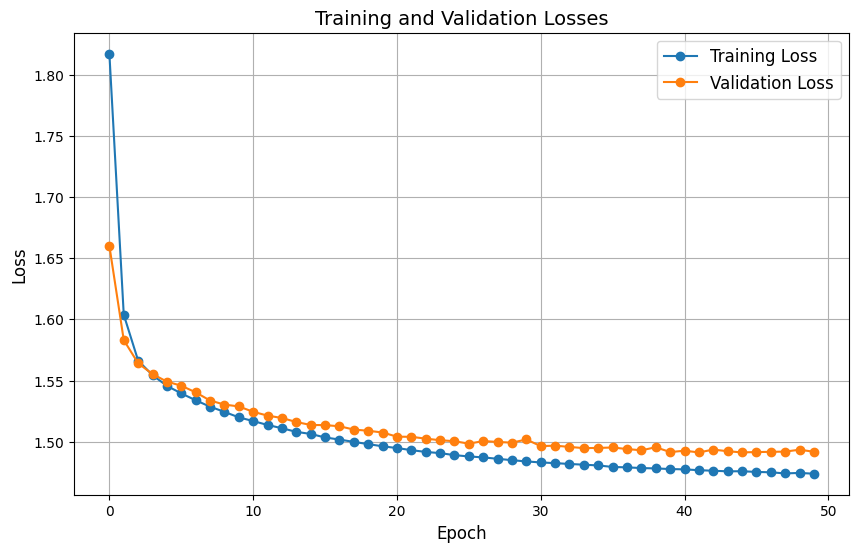

Test Loss: 1.4897
Test Accuracy: 0.9721
Test F1 Score: 0.9721
Test Loss: 1.4897
Test Accuracy: 0.9721
Test F1 Score: 0.9721


In [24]:
# Unpack model configuration
input_dim = model_1_config["input_dim"]
hidden_dim = model_1_config["hidden_dim"]
out_dim = model_1_config["out_dim"]
num_layers = model_1_config["num_layers"]
dropout = model_1_config["dropout"]
dropout_p = model_1_config["dropout_p"]

# Initialize the model
model = MyModel(
    input_dim=input_dim,
    hidden_dims=[hidden_dim] * num_layers,  # Create hidden layers dynamically
    output_dim=out_dim,
    dropout_probs=[dropout_p if d else 0 for d in dropout]
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
trained_model, train_losses, val_losses = trainer(
    model=model,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer,
    epochs=50,  # Maximum number of epochs
    early_stopping=False,  # No early stopping for this experiment
    patience=10  # Not used since early stopping is disabled
)

# Plot training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1 = evaluate_model(trained_model, test_dl, criterion)

# Print test evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

m1_acc = test_accuracy
m1_f1 = test_f1

### Experiment 2: Deep regularized network (with weight-decay enabled)

Use the given model configs to run the experiments.

In [25]:
# Deep network (3 hidden layers) with weight-decay but no dropout
model_2_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}


learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

Validation Epoch 1/50: 100%|██████████| 188/188 [00:00<00:00, 350.83it/s]


Epoch 1/50, Train Loss: 1.8076, Val Loss: 1.6267


Validation Epoch 2/50: 100%|██████████| 188/188 [00:00<00:00, 342.87it/s]


Epoch 2/50, Train Loss: 1.5901, Val Loss: 1.5762


Validation Epoch 3/50: 100%|██████████| 188/188 [00:00<00:00, 338.72it/s]


Epoch 3/50, Train Loss: 1.5671, Val Loss: 1.5615


Validation Epoch 4/50: 100%|██████████| 188/188 [00:00<00:00, 330.70it/s]


Epoch 4/50, Train Loss: 1.5556, Val Loss: 1.5569


Validation Epoch 5/50: 100%|██████████| 188/188 [00:00<00:00, 320.35it/s]


Epoch 5/50, Train Loss: 1.5482, Val Loss: 1.5512


Validation Epoch 6/50: 100%|██████████| 188/188 [00:00<00:00, 312.21it/s]


Epoch 6/50, Train Loss: 1.5417, Val Loss: 1.5452


Validation Epoch 7/50: 100%|██████████| 188/188 [00:00<00:00, 301.01it/s]


Epoch 7/50, Train Loss: 1.5374, Val Loss: 1.5419


Validation Epoch 8/50: 100%|██████████| 188/188 [00:00<00:00, 290.14it/s]


Epoch 8/50, Train Loss: 1.5327, Val Loss: 1.5387


Validation Epoch 9/50: 100%|██████████| 188/188 [00:00<00:00, 284.82it/s]


Epoch 9/50, Train Loss: 1.5282, Val Loss: 1.5399


Validation Epoch 10/50: 100%|██████████| 188/188 [00:00<00:00, 280.58it/s]


Epoch 10/50, Train Loss: 1.5250, Val Loss: 1.5311


Validation Epoch 11/50: 100%|██████████| 188/188 [00:00<00:00, 267.91it/s]


Epoch 11/50, Train Loss: 1.5217, Val Loss: 1.5317


Validation Epoch 12/50: 100%|██████████| 188/188 [00:00<00:00, 268.91it/s]


Epoch 12/50, Train Loss: 1.5181, Val Loss: 1.5266


Validation Epoch 13/50: 100%|██████████| 188/188 [00:00<00:00, 266.36it/s]


Epoch 13/50, Train Loss: 1.5155, Val Loss: 1.5260


Validation Epoch 14/50: 100%|██████████| 188/188 [00:00<00:00, 263.56it/s]


Epoch 14/50, Train Loss: 1.5134, Val Loss: 1.5239


Validation Epoch 15/50: 100%|██████████| 188/188 [00:00<00:00, 237.17it/s]


Epoch 15/50, Train Loss: 1.5114, Val Loss: 1.5209


Validation Epoch 16/50: 100%|██████████| 188/188 [00:00<00:00, 266.96it/s]


Epoch 16/50, Train Loss: 1.5092, Val Loss: 1.5172


Validation Epoch 17/50: 100%|██████████| 188/188 [00:00<00:00, 268.31it/s]


Epoch 17/50, Train Loss: 1.5064, Val Loss: 1.5197


Validation Epoch 18/50: 100%|██████████| 188/188 [00:00<00:00, 269.16it/s]


Epoch 18/50, Train Loss: 1.5048, Val Loss: 1.5141


Validation Epoch 19/50: 100%|██████████| 188/188 [00:00<00:00, 277.10it/s]


Epoch 19/50, Train Loss: 1.5029, Val Loss: 1.5146


Validation Epoch 20/50: 100%|██████████| 188/188 [00:00<00:00, 277.99it/s]


Epoch 20/50, Train Loss: 1.5010, Val Loss: 1.5128


Validation Epoch 21/50: 100%|██████████| 188/188 [00:00<00:00, 286.10it/s]


Epoch 21/50, Train Loss: 1.4992, Val Loss: 1.5101


Validation Epoch 22/50: 100%|██████████| 188/188 [00:00<00:00, 253.43it/s]


Epoch 22/50, Train Loss: 1.4978, Val Loss: 1.5097


Validation Epoch 23/50: 100%|██████████| 188/188 [00:00<00:00, 291.03it/s]


Epoch 23/50, Train Loss: 1.4958, Val Loss: 1.5091


Validation Epoch 24/50: 100%|██████████| 188/188 [00:00<00:00, 291.59it/s]


Epoch 24/50, Train Loss: 1.4945, Val Loss: 1.5069


Validation Epoch 25/50: 100%|██████████| 188/188 [00:00<00:00, 296.07it/s]


Epoch 25/50, Train Loss: 1.4935, Val Loss: 1.5054


Validation Epoch 26/50: 100%|██████████| 188/188 [00:00<00:00, 299.45it/s]


Epoch 26/50, Train Loss: 1.4918, Val Loss: 1.5081


Validation Epoch 27/50: 100%|██████████| 188/188 [00:00<00:00, 303.07it/s]


Epoch 27/50, Train Loss: 1.4906, Val Loss: 1.5047


Validation Epoch 28/50: 100%|██████████| 188/188 [00:00<00:00, 303.98it/s]


Epoch 28/50, Train Loss: 1.4898, Val Loss: 1.5013


Validation Epoch 29/50: 100%|██████████| 188/188 [00:00<00:00, 306.60it/s]


Epoch 29/50, Train Loss: 1.4885, Val Loss: 1.5037


Validation Epoch 30/50: 100%|██████████| 188/188 [00:00<00:00, 313.50it/s]


Epoch 30/50, Train Loss: 1.4878, Val Loss: 1.4997


Validation Epoch 31/50: 100%|██████████| 188/188 [00:00<00:00, 317.70it/s]


Epoch 31/50, Train Loss: 1.4862, Val Loss: 1.5002


Validation Epoch 32/50: 100%|██████████| 188/188 [00:00<00:00, 320.14it/s]


Epoch 32/50, Train Loss: 1.4853, Val Loss: 1.4983


Validation Epoch 33/50: 100%|██████████| 188/188 [00:00<00:00, 318.99it/s]


Epoch 33/50, Train Loss: 1.4846, Val Loss: 1.5009


Validation Epoch 34/50: 100%|██████████| 188/188 [00:00<00:00, 321.08it/s]


Epoch 34/50, Train Loss: 1.4840, Val Loss: 1.4972


Validation Epoch 35/50: 100%|██████████| 188/188 [00:00<00:00, 317.46it/s]


Epoch 35/50, Train Loss: 1.4831, Val Loss: 1.4980


Validation Epoch 36/50: 100%|██████████| 188/188 [00:00<00:00, 323.13it/s]


Epoch 36/50, Train Loss: 1.4824, Val Loss: 1.4951


Validation Epoch 37/50: 100%|██████████| 188/188 [00:00<00:00, 315.62it/s]


Epoch 37/50, Train Loss: 1.4822, Val Loss: 1.4960


Validation Epoch 38/50: 100%|██████████| 188/188 [00:00<00:00, 322.49it/s]


Epoch 38/50, Train Loss: 1.4812, Val Loss: 1.4938


Validation Epoch 39/50: 100%|██████████| 188/188 [00:00<00:00, 315.65it/s]


Epoch 39/50, Train Loss: 1.4804, Val Loss: 1.4932


Validation Epoch 40/50: 100%|██████████| 188/188 [00:00<00:00, 314.97it/s]


Epoch 40/50, Train Loss: 1.4804, Val Loss: 1.4949


Validation Epoch 41/50: 100%|██████████| 188/188 [00:00<00:00, 318.67it/s]


Epoch 41/50, Train Loss: 1.4795, Val Loss: 1.4936


Validation Epoch 42/50: 100%|██████████| 188/188 [00:00<00:00, 259.08it/s]


Epoch 42/50, Train Loss: 1.4788, Val Loss: 1.4943


Validation Epoch 43/50: 100%|██████████| 188/188 [00:00<00:00, 316.93it/s]


Epoch 43/50, Train Loss: 1.4786, Val Loss: 1.4939


Validation Epoch 44/50: 100%|██████████| 188/188 [00:00<00:00, 314.95it/s]


Epoch 44/50, Train Loss: 1.4775, Val Loss: 1.4938


Validation Epoch 45/50: 100%|██████████| 188/188 [00:00<00:00, 322.62it/s]


Epoch 45/50, Train Loss: 1.4778, Val Loss: 1.4945


Validation Epoch 46/50: 100%|██████████| 188/188 [00:00<00:00, 320.13it/s]


Epoch 46/50, Train Loss: 1.4770, Val Loss: 1.4942


Validation Epoch 47/50: 100%|██████████| 188/188 [00:00<00:00, 310.65it/s]


Epoch 47/50, Train Loss: 1.4765, Val Loss: 1.4922


Validation Epoch 48/50: 100%|██████████| 188/188 [00:00<00:00, 320.12it/s]


Epoch 48/50, Train Loss: 1.4763, Val Loss: 1.4920


Validation Epoch 49/50: 100%|██████████| 188/188 [00:00<00:00, 318.26it/s]


Epoch 49/50, Train Loss: 1.4759, Val Loss: 1.4922


Validation Epoch 50/50: 100%|██████████| 188/188 [00:00<00:00, 319.39it/s]


Epoch 50/50, Train Loss: 1.4754, Val Loss: 1.4912


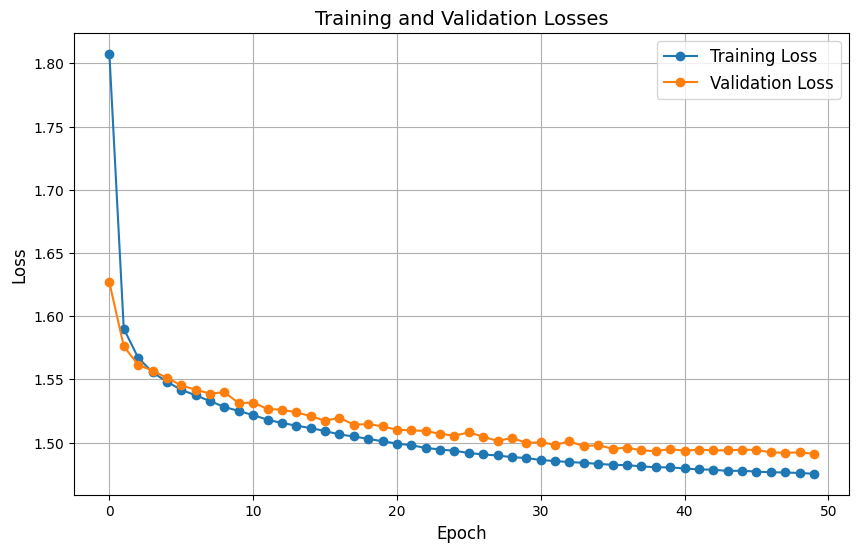

Test Loss: 1.4903
Test Accuracy: 0.9721
Test F1 Score: 0.9721
Test Loss: 1.4903
Test Accuracy: 0.9721
Test F1 Score: 0.9721


In [26]:
# Unpack model configuration
input_dim = model_2_config["input_dim"]
hidden_dim = model_2_config["hidden_dim"]
out_dim = model_2_config["out_dim"]
num_layers = model_2_config["num_layers"]
dropout = model_2_config["dropout"]
dropout_p = model_2_config["dropout_p"]

# Initialize the model
model = MyModel(
    input_dim=input_dim,
    hidden_dims=[hidden_dim] * num_layers,  # Create hidden layers dynamically
    output_dim=out_dim,
    dropout_probs=[dropout_p if d else 0 for d in dropout]
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
trained_model, train_losses, val_losses = trainer(
    model=model,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer,
    epochs=50,  # Maximum number of epochs
    early_stopping=False,  # No early stopping for this experiment
    patience=10  # Not used since early stopping is disabled
)

# Plot training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1 = evaluate_model(trained_model, test_dl, criterion)

# Print test evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

m2_acc = test_accuracy
m2_f1 = test_f1

### Experiment 3: Deep regularized network (with weight-decay and dropout)

Use the given model configs to run the experiments.

In [27]:
# Deep regularized network (3 hidden layers) with weight-decay and dropout after every layer
model_3_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [True, True, True],
    "dropout_p": 0.5
}

learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

Validation Epoch 1/50: 100%|██████████| 188/188 [00:00<00:00, 317.71it/s]


Epoch 1/50, Train Loss: 2.0180, Val Loss: 1.7668


Validation Epoch 2/50: 100%|██████████| 188/188 [00:00<00:00, 313.65it/s]


Epoch 2/50, Train Loss: 1.7301, Val Loss: 1.6209


Validation Epoch 3/50: 100%|██████████| 188/188 [00:00<00:00, 317.78it/s]


Epoch 3/50, Train Loss: 1.6383, Val Loss: 1.5833


Validation Epoch 4/50: 100%|██████████| 188/188 [00:00<00:00, 320.46it/s]


Epoch 4/50, Train Loss: 1.6042, Val Loss: 1.5693


Validation Epoch 5/50: 100%|██████████| 188/188 [00:00<00:00, 314.03it/s]


Epoch 5/50, Train Loss: 1.5880, Val Loss: 1.5617


Validation Epoch 6/50: 100%|██████████| 188/188 [00:00<00:00, 316.83it/s]


Epoch 6/50, Train Loss: 1.5767, Val Loss: 1.5541


Validation Epoch 7/50: 100%|██████████| 188/188 [00:00<00:00, 321.24it/s]


Epoch 7/50, Train Loss: 1.5674, Val Loss: 1.5473


Validation Epoch 8/50: 100%|██████████| 188/188 [00:00<00:00, 321.04it/s]


Epoch 8/50, Train Loss: 1.5593, Val Loss: 1.5425


Validation Epoch 9/50: 100%|██████████| 188/188 [00:00<00:00, 317.11it/s]


Epoch 9/50, Train Loss: 1.5531, Val Loss: 1.5384


Validation Epoch 10/50: 100%|██████████| 188/188 [00:00<00:00, 322.24it/s]


Epoch 10/50, Train Loss: 1.5491, Val Loss: 1.5363


Validation Epoch 11/50: 100%|██████████| 188/188 [00:00<00:00, 316.76it/s]


Epoch 11/50, Train Loss: 1.5441, Val Loss: 1.5314


Validation Epoch 12/50: 100%|██████████| 188/188 [00:00<00:00, 323.09it/s]


Epoch 12/50, Train Loss: 1.5415, Val Loss: 1.5291


Validation Epoch 13/50: 100%|██████████| 188/188 [00:00<00:00, 318.41it/s]


Epoch 13/50, Train Loss: 1.5363, Val Loss: 1.5292


Validation Epoch 14/50: 100%|██████████| 188/188 [00:00<00:00, 299.20it/s]


Epoch 14/50, Train Loss: 1.5341, Val Loss: 1.5249


Validation Epoch 15/50: 100%|██████████| 188/188 [00:00<00:00, 305.80it/s]


Epoch 15/50, Train Loss: 1.5305, Val Loss: 1.5216


Validation Epoch 16/50: 100%|██████████| 188/188 [00:00<00:00, 309.03it/s]


Epoch 16/50, Train Loss: 1.5283, Val Loss: 1.5197


Validation Epoch 17/50: 100%|██████████| 188/188 [00:00<00:00, 317.71it/s]


Epoch 17/50, Train Loss: 1.5261, Val Loss: 1.5177


Validation Epoch 18/50: 100%|██████████| 188/188 [00:00<00:00, 313.33it/s]


Epoch 18/50, Train Loss: 1.5231, Val Loss: 1.5152


Validation Epoch 19/50: 100%|██████████| 188/188 [00:00<00:00, 318.85it/s]


Epoch 19/50, Train Loss: 1.5211, Val Loss: 1.5158


Validation Epoch 20/50: 100%|██████████| 188/188 [00:00<00:00, 317.23it/s]


Epoch 20/50, Train Loss: 1.5191, Val Loss: 1.5136


Validation Epoch 21/50: 100%|██████████| 188/188 [00:00<00:00, 315.32it/s]


Epoch 21/50, Train Loss: 1.5174, Val Loss: 1.5109


Validation Epoch 22/50: 100%|██████████| 188/188 [00:00<00:00, 318.41it/s]


Epoch 22/50, Train Loss: 1.5169, Val Loss: 1.5115


Validation Epoch 23/50: 100%|██████████| 188/188 [00:00<00:00, 316.82it/s]


Epoch 23/50, Train Loss: 1.5151, Val Loss: 1.5095


Validation Epoch 24/50: 100%|██████████| 188/188 [00:00<00:00, 314.53it/s]


Epoch 24/50, Train Loss: 1.5131, Val Loss: 1.5086


Validation Epoch 25/50: 100%|██████████| 188/188 [00:00<00:00, 315.37it/s]


Epoch 25/50, Train Loss: 1.5124, Val Loss: 1.5072


Validation Epoch 26/50: 100%|██████████| 188/188 [00:00<00:00, 319.75it/s]


Epoch 26/50, Train Loss: 1.5116, Val Loss: 1.5064


Validation Epoch 27/50: 100%|██████████| 188/188 [00:00<00:00, 312.86it/s]


Epoch 27/50, Train Loss: 1.5089, Val Loss: 1.5051


Validation Epoch 28/50: 100%|██████████| 188/188 [00:00<00:00, 320.21it/s]


Epoch 28/50, Train Loss: 1.5088, Val Loss: 1.5040


Validation Epoch 29/50: 100%|██████████| 188/188 [00:00<00:00, 323.01it/s]


Epoch 29/50, Train Loss: 1.5074, Val Loss: 1.5034


Validation Epoch 30/50: 100%|██████████| 188/188 [00:00<00:00, 316.61it/s]


Epoch 30/50, Train Loss: 1.5072, Val Loss: 1.5017


Validation Epoch 31/50: 100%|██████████| 188/188 [00:00<00:00, 315.10it/s]


Epoch 31/50, Train Loss: 1.5060, Val Loss: 1.5031


Validation Epoch 32/50: 100%|██████████| 188/188 [00:00<00:00, 315.60it/s]


Epoch 32/50, Train Loss: 1.5062, Val Loss: 1.5015


Validation Epoch 33/50: 100%|██████████| 188/188 [00:00<00:00, 317.14it/s]


Epoch 33/50, Train Loss: 1.5037, Val Loss: 1.5015


Validation Epoch 34/50: 100%|██████████| 188/188 [00:00<00:00, 318.50it/s]


Epoch 34/50, Train Loss: 1.5029, Val Loss: 1.4997


Validation Epoch 35/50: 100%|██████████| 188/188 [00:00<00:00, 319.73it/s]


Epoch 35/50, Train Loss: 1.5025, Val Loss: 1.5001


Validation Epoch 36/50: 100%|██████████| 188/188 [00:00<00:00, 315.63it/s]


Epoch 36/50, Train Loss: 1.5020, Val Loss: 1.4990


Validation Epoch 37/50: 100%|██████████| 188/188 [00:00<00:00, 319.16it/s]


Epoch 37/50, Train Loss: 1.5022, Val Loss: 1.4982


Validation Epoch 38/50: 100%|██████████| 188/188 [00:00<00:00, 321.96it/s]


Epoch 38/50, Train Loss: 1.5005, Val Loss: 1.4977


Validation Epoch 39/50: 100%|██████████| 188/188 [00:00<00:00, 316.02it/s]


Epoch 39/50, Train Loss: 1.5006, Val Loss: 1.4969


Validation Epoch 40/50: 100%|██████████| 188/188 [00:00<00:00, 315.42it/s]


Epoch 40/50, Train Loss: 1.4992, Val Loss: 1.4976


Validation Epoch 41/50: 100%|██████████| 188/188 [00:00<00:00, 316.85it/s]


Epoch 41/50, Train Loss: 1.4993, Val Loss: 1.4973


Validation Epoch 42/50: 100%|██████████| 188/188 [00:00<00:00, 313.63it/s]


Epoch 42/50, Train Loss: 1.4985, Val Loss: 1.4977


Validation Epoch 43/50: 100%|██████████| 188/188 [00:00<00:00, 312.73it/s]


Epoch 43/50, Train Loss: 1.4966, Val Loss: 1.4960


Validation Epoch 44/50: 100%|██████████| 188/188 [00:00<00:00, 319.80it/s]


Epoch 44/50, Train Loss: 1.4963, Val Loss: 1.4949


Validation Epoch 45/50: 100%|██████████| 188/188 [00:00<00:00, 320.62it/s]


Epoch 45/50, Train Loss: 1.4970, Val Loss: 1.4954


Validation Epoch 46/50: 100%|██████████| 188/188 [00:00<00:00, 315.40it/s]


Epoch 46/50, Train Loss: 1.4967, Val Loss: 1.4942


Validation Epoch 47/50: 100%|██████████| 188/188 [00:00<00:00, 318.80it/s]


Epoch 47/50, Train Loss: 1.4968, Val Loss: 1.4939


Validation Epoch 48/50: 100%|██████████| 188/188 [00:00<00:00, 314.47it/s]


Epoch 48/50, Train Loss: 1.4960, Val Loss: 1.4945


Validation Epoch 49/50: 100%|██████████| 188/188 [00:00<00:00, 319.79it/s]


Epoch 49/50, Train Loss: 1.4949, Val Loss: 1.4948


Validation Epoch 50/50: 100%|██████████| 188/188 [00:00<00:00, 316.73it/s]


Epoch 50/50, Train Loss: 1.4941, Val Loss: 1.4941


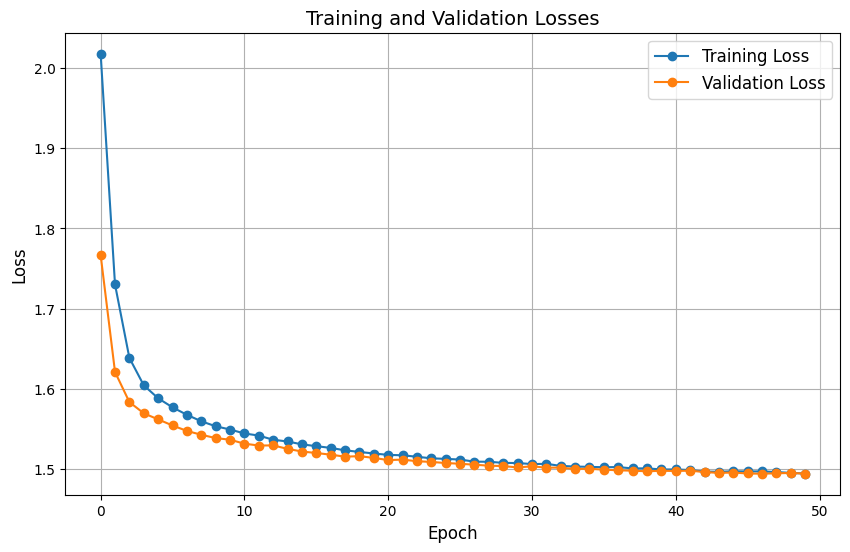

Test Loss: 1.4901
Test Accuracy: 0.9723
Test F1 Score: 0.9723
Test Loss: 1.4901
Test Accuracy: 0.9723
Test F1 Score: 0.9723


In [28]:
# Unpack model configuration
input_dim = model_3_config["input_dim"]
hidden_dim = model_3_config["hidden_dim"]
out_dim = model_3_config["out_dim"]
num_layers = model_3_config["num_layers"]
dropout = model_3_config["dropout"]
dropout_p = model_3_config["dropout_p"]

# Initialize the model
model = MyModel(
    input_dim=input_dim,
    hidden_dims=[hidden_dim] * num_layers,  # Create hidden layers dynamically
    output_dim=out_dim,
    dropout_probs=[dropout_p if d else 0 for d in dropout]
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
trained_model, train_losses, val_losses = trainer(
    model=model,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer,
    epochs=50,  # Maximum number of epochs
    early_stopping=False,  # No early stopping for this experiment
    patience=10  # Not used since early stopping is disabled
)

# Plot training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1 = evaluate_model(trained_model, test_dl, criterion)

# Print test evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

m3_acc = test_accuracy
m3_f1 = test_f1

### Experiment 4: Deep regularized network (with weight-decay and early-stopping)

Use the given model configs to run the experiments.

In [29]:
# Deep regularized network (3 hidden layers) with weight-decay and early stopping
model_4_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}

learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

Validation Epoch 1/50: 100%|██████████| 188/188 [00:00<00:00, 316.46it/s]


Epoch 1/50, Train Loss: 1.7865, Val Loss: 1.6066


Validation Epoch 2/50: 100%|██████████| 188/188 [00:00<00:00, 312.32it/s]


Epoch 2/50, Train Loss: 1.5843, Val Loss: 1.5729


Validation Epoch 3/50: 100%|██████████| 188/188 [00:00<00:00, 311.47it/s]


Epoch 3/50, Train Loss: 1.5636, Val Loss: 1.5608


Validation Epoch 4/50: 100%|██████████| 188/188 [00:00<00:00, 312.45it/s]


Epoch 4/50, Train Loss: 1.5525, Val Loss: 1.5542


Validation Epoch 5/50: 100%|██████████| 188/188 [00:00<00:00, 312.14it/s]


Epoch 5/50, Train Loss: 1.5444, Val Loss: 1.5460


Validation Epoch 6/50: 100%|██████████| 188/188 [00:00<00:00, 316.48it/s]


Epoch 6/50, Train Loss: 1.5380, Val Loss: 1.5440


Validation Epoch 7/50: 100%|██████████| 188/188 [00:00<00:00, 308.81it/s]


Epoch 7/50, Train Loss: 1.5328, Val Loss: 1.5415


Validation Epoch 8/50: 100%|██████████| 188/188 [00:00<00:00, 277.12it/s]


Epoch 8/50, Train Loss: 1.5286, Val Loss: 1.5322


Validation Epoch 9/50: 100%|██████████| 188/188 [00:00<00:00, 311.90it/s]


Epoch 9/50, Train Loss: 1.5249, Val Loss: 1.5316


Validation Epoch 10/50: 100%|██████████| 188/188 [00:00<00:00, 312.95it/s]


Epoch 10/50, Train Loss: 1.5209, Val Loss: 1.5311


Validation Epoch 11/50: 100%|██████████| 188/188 [00:00<00:00, 310.82it/s]


Epoch 11/50, Train Loss: 1.5177, Val Loss: 1.5258


Validation Epoch 12/50: 100%|██████████| 188/188 [00:00<00:00, 312.08it/s]


Epoch 12/50, Train Loss: 1.5146, Val Loss: 1.5224


Validation Epoch 13/50: 100%|██████████| 188/188 [00:00<00:00, 313.61it/s]


Epoch 13/50, Train Loss: 1.5118, Val Loss: 1.5219


Validation Epoch 14/50: 100%|██████████| 188/188 [00:00<00:00, 311.75it/s]


Epoch 14/50, Train Loss: 1.5088, Val Loss: 1.5183


Validation Epoch 15/50: 100%|██████████| 188/188 [00:00<00:00, 309.12it/s]


Epoch 15/50, Train Loss: 1.5069, Val Loss: 1.5153


Validation Epoch 16/50: 100%|██████████| 188/188 [00:00<00:00, 312.94it/s]


Epoch 16/50, Train Loss: 1.5046, Val Loss: 1.5173


Validation Epoch 17/50: 100%|██████████| 188/188 [00:00<00:00, 305.69it/s]


Epoch 17/50, Train Loss: 1.5022, Val Loss: 1.5185


Validation Epoch 18/50: 100%|██████████| 188/188 [00:00<00:00, 310.78it/s]


Epoch 18/50, Train Loss: 1.5008, Val Loss: 1.5116


Validation Epoch 19/50: 100%|██████████| 188/188 [00:00<00:00, 311.62it/s]


Epoch 19/50, Train Loss: 1.4986, Val Loss: 1.5099


Validation Epoch 20/50: 100%|██████████| 188/188 [00:00<00:00, 306.50it/s]


Epoch 20/50, Train Loss: 1.4972, Val Loss: 1.5098


Validation Epoch 21/50: 100%|██████████| 188/188 [00:00<00:00, 311.08it/s]


Epoch 21/50, Train Loss: 1.4953, Val Loss: 1.5072


Validation Epoch 22/50: 100%|██████████| 188/188 [00:00<00:00, 312.95it/s]


Epoch 22/50, Train Loss: 1.4939, Val Loss: 1.5047


Validation Epoch 23/50: 100%|██████████| 188/188 [00:00<00:00, 311.26it/s]


Epoch 23/50, Train Loss: 1.4924, Val Loss: 1.5056


Validation Epoch 24/50: 100%|██████████| 188/188 [00:00<00:00, 285.32it/s]


Epoch 24/50, Train Loss: 1.4911, Val Loss: 1.5019


Validation Epoch 25/50: 100%|██████████| 188/188 [00:00<00:00, 309.30it/s]


Epoch 25/50, Train Loss: 1.4899, Val Loss: 1.5021


Validation Epoch 26/50: 100%|██████████| 188/188 [00:00<00:00, 307.33it/s]


Epoch 26/50, Train Loss: 1.4885, Val Loss: 1.5012


Validation Epoch 27/50: 100%|██████████| 188/188 [00:00<00:00, 312.85it/s]


Epoch 27/50, Train Loss: 1.4875, Val Loss: 1.5001


Validation Epoch 28/50: 100%|██████████| 188/188 [00:00<00:00, 311.79it/s]


Epoch 28/50, Train Loss: 1.4864, Val Loss: 1.5061


Validation Epoch 29/50: 100%|██████████| 188/188 [00:00<00:00, 314.10it/s]


Epoch 29/50, Train Loss: 1.4858, Val Loss: 1.5004


Validation Epoch 30/50: 100%|██████████| 188/188 [00:00<00:00, 308.91it/s]


Epoch 30/50, Train Loss: 1.4848, Val Loss: 1.4971


Validation Epoch 31/50: 100%|██████████| 188/188 [00:00<00:00, 302.54it/s]


Epoch 31/50, Train Loss: 1.4841, Val Loss: 1.4967


Validation Epoch 32/50: 100%|██████████| 188/188 [00:00<00:00, 305.91it/s]


Epoch 32/50, Train Loss: 1.4831, Val Loss: 1.4974


Validation Epoch 33/50: 100%|██████████| 188/188 [00:00<00:00, 306.55it/s]


Epoch 33/50, Train Loss: 1.4820, Val Loss: 1.4987


Validation Epoch 34/50: 100%|██████████| 188/188 [00:00<00:00, 306.72it/s]


Epoch 34/50, Train Loss: 1.4816, Val Loss: 1.4953


Validation Epoch 35/50: 100%|██████████| 188/188 [00:00<00:00, 304.60it/s]


Epoch 35/50, Train Loss: 1.4808, Val Loss: 1.4954


Validation Epoch 36/50: 100%|██████████| 188/188 [00:00<00:00, 277.33it/s]


Epoch 36/50, Train Loss: 1.4801, Val Loss: 1.4935


Validation Epoch 37/50: 100%|██████████| 188/188 [00:00<00:00, 309.87it/s]


Epoch 37/50, Train Loss: 1.4799, Val Loss: 1.4954


Validation Epoch 38/50: 100%|██████████| 188/188 [00:00<00:00, 307.47it/s]


Epoch 38/50, Train Loss: 1.4787, Val Loss: 1.4929


Validation Epoch 39/50: 100%|██████████| 188/188 [00:00<00:00, 308.93it/s]


Epoch 39/50, Train Loss: 1.4783, Val Loss: 1.4956


Validation Epoch 40/50: 100%|██████████| 188/188 [00:00<00:00, 310.28it/s]


Epoch 40/50, Train Loss: 1.4783, Val Loss: 1.4964


Validation Epoch 41/50: 100%|██████████| 188/188 [00:00<00:00, 311.05it/s]


Epoch 41/50, Train Loss: 1.4774, Val Loss: 1.4938


Validation Epoch 42/50: 100%|██████████| 188/188 [00:00<00:00, 309.31it/s]


Epoch 42/50, Train Loss: 1.4770, Val Loss: 1.4947


Validation Epoch 43/50: 100%|██████████| 188/188 [00:00<00:00, 304.12it/s]


Epoch 43/50, Train Loss: 1.4765, Val Loss: 1.4916


Validation Epoch 44/50: 100%|██████████| 188/188 [00:00<00:00, 311.48it/s]


Epoch 44/50, Train Loss: 1.4766, Val Loss: 1.4925


Validation Epoch 45/50: 100%|██████████| 188/188 [00:00<00:00, 308.40it/s]


Epoch 45/50, Train Loss: 1.4759, Val Loss: 1.4906


Validation Epoch 46/50: 100%|██████████| 188/188 [00:00<00:00, 307.74it/s]


Epoch 46/50, Train Loss: 1.4753, Val Loss: 1.4917


Validation Epoch 47/50: 100%|██████████| 188/188 [00:00<00:00, 308.81it/s]


Epoch 47/50, Train Loss: 1.4753, Val Loss: 1.4916


Validation Epoch 48/50: 100%|██████████| 188/188 [00:00<00:00, 310.19it/s]


Epoch 48/50, Train Loss: 1.4751, Val Loss: 1.4915


Validation Epoch 49/50: 100%|██████████| 188/188 [00:00<00:00, 310.83it/s]


Epoch 49/50, Train Loss: 1.4743, Val Loss: 1.4921


Validation Epoch 50/50: 100%|██████████| 188/188 [00:00<00:00, 312.84it/s]


Epoch 50/50, Train Loss: 1.4746, Val Loss: 1.4902


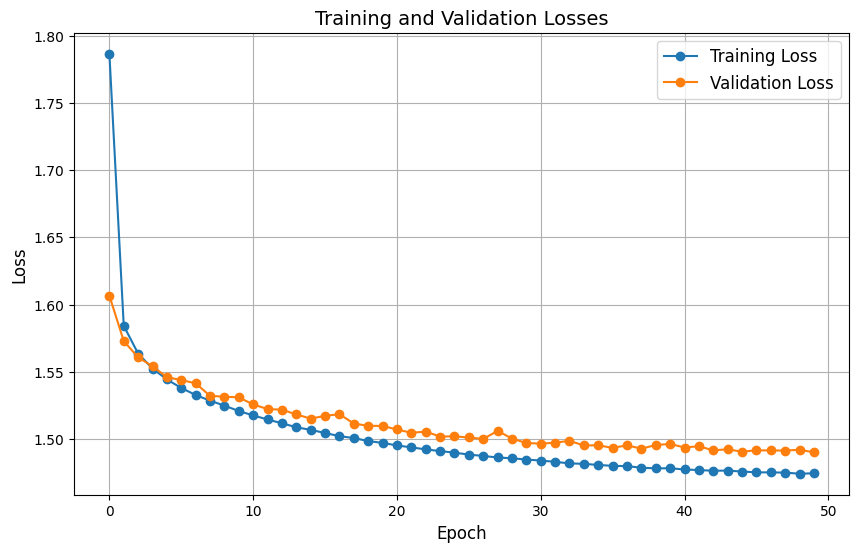

Test Loss: 1.4887
Test Accuracy: 0.9731
Test F1 Score: 0.9731
Test Loss: 1.4887
Test Accuracy: 0.9731
Test F1 Score: 0.9731


In [30]:
# Unpack model configuration
input_dim = model_4_config["input_dim"]
hidden_dim = model_4_config["hidden_dim"]
out_dim = model_4_config["out_dim"]
num_layers = model_4_config["num_layers"]
dropout = model_4_config["dropout"]
dropout_p = model_4_config["dropout_p"]

# Initialize the model
model = MyModel(
    input_dim=input_dim,
    hidden_dims=[hidden_dim] * num_layers,  # Create hidden layers dynamically
    output_dim=out_dim,
    dropout_probs=[dropout_p if d else 0 for d in dropout]
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
trained_model, train_losses, val_losses = trainer(
    model=model,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer,
    epochs=50,  # Maximum number of epochs
    early_stopping=True,  # Enable early stopping for this experiment
    patience=10  # Set patience for early stopping
)

# Plot training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1 = evaluate_model(trained_model, test_dl, criterion)

# Print test evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

m4_acc = test_accuracy
m4_f1 = test_f1

In [31]:
#Report the model accuracies and F1-score on the test set

print('Model 1: Deep network (3 hidden layers) with no dropout and no weight-decay')
print(f"Test Accuracy: {m1_acc:.4f}")
print(f"Test F1 Score: {m1_f1:.4f}")
print('Model 2: Deep network (3 hidden layers) with weight-decay but no dropout')
print(f"Test Accuracy: {m2_acc:.4f}")
print(f"Test F1 Score: {m2_f1:.4f}")
print('Model 3: Deep regularized network (3 hidden layers) with weight-decay and dropout after every layer')
print(f"Test Accuracy: {m3_acc:.4f}")
print(f"Test F1 Score: {m3_f1:.4f}")
print('Model 4: Deep regularized network (3 hidden layers) with weight-decay and early stopping')
print(f"Test Accuracy: {m4_acc:.4f}")
print(f"Test F1 Score: {m4_f1:.4f}")

Model 1: Deep network (3 hidden layers) with no dropout and no weight-decay
Test Accuracy: 0.9721
Test F1 Score: 0.9721
Model 2: Deep network (3 hidden layers) with weight-decay but no dropout
Test Accuracy: 0.9721
Test F1 Score: 0.9721
Model 3: Deep regularized network (3 hidden layers) with weight-decay and dropout after every layer
Test Accuracy: 0.9723
Test F1 Score: 0.9723
Model 4: Deep regularized network (3 hidden layers) with weight-decay and early stopping
Test Accuracy: 0.9731
Test F1 Score: 0.9731
